In [16]:
pip install mplfinance

Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from prophet import Prophet

import statsmodels.api as sm
from scipy import stats
import mplfinance as mpf
from plotly import tools
import matplotlib.dates as mdates
import chart_studio.plotly as py
import plotly.figure_factory as ff
import chart_studio.tools as tls
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from chart_studio.plotly import plot, iplot
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


#### 1. Forecasting Saham ADRO

In [2]:
# Load data
adro = pd.read_csv("Stock/ADRO.JK.csv")

# Tambah Kolom Kode Saham
adro['Kode'] = 'ADRO'

# Tampilkan Data
adro

,Date,Open,High,Low,Close,Adj Close,Volume,Kode
0,2008-08-01,1630.0,1680.0,1620.0,1630.0,625.735046,78478500.0,ADRO
1,2008-08-04,1590.0,1630.0,1590.0,1590.0,610.379700,43837000.0,ADRO
2,2008-08-05,1550.0,1580.0,1540.0,1550.0,595.024109,50244500.0,ADRO
3,2008-08-06,1540.0,1570.0,1540.0,1540.0,591.185242,48545500.0,ADRO
4,2008-08-07,1560.0,1570.0,1540.0,1560.0,598.863159,50999500.0,ADRO
...,...,...,...,...,...,...,...,...
3960,2024-08-29,3540.0,3590.0,3500.0,3520.0,3520.000000,63218700.0,ADRO
3961,2024-08-30,3540.0,3590.0,3510.0,3560.0,3560.000000,95767700.0,ADRO
3962,2024-09-02,3590.0,3650.0,3570.0,3610.0,3610.000000,96348100.0,ADRO
3963,2024-09-03,NaN,NaN,NaN,NaN,NaN,NaN,ADRO


In [3]:
# Handle Missing Values
adro = adro.dropna()

# mengecek missing values
adro.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Kode         0
dtype: int64

In [4]:
# mengubah tipe data kolom 'Date' menjadi datetime
adro['Date'] = pd.to_datetime(adro['Date'], format="%Y-%m-%d")

# mengecek informasi dataset
adro.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3963 entries, 0 to 3964
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3963 non-null   datetime64[ns]
 1   Open       3963 non-null   float64       
 2   High       3963 non-null   float64       
 3   Low        3963 non-null   float64       
 4   Close      3963 non-null   float64       
 5   Adj Close  3963 non-null   float64       
 6   Volume     3963 non-null   float64       
 7   Kode       3963 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 278.6+ KB


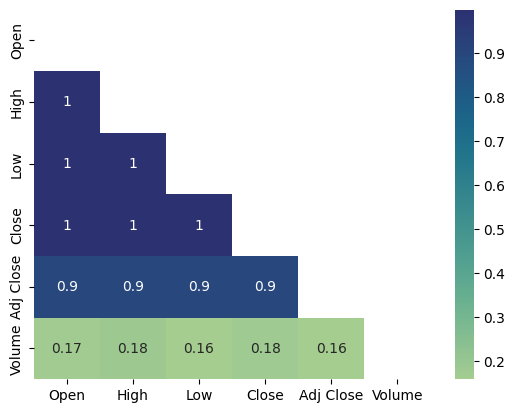

In [5]:
mask_adro = np.triu(np.ones_like(adro.corr(numeric_only=True))).astype(bool)
sns.heatmap(adro.corr(numeric_only=True), annot=True, mask=mask_adro, cmap='crest')
plt.show()

In [6]:
model = Prophet()

# Drop columns
model_df = adro.drop(['Open', 'High', 'Low', 'Volume', 'Kode', 'Adj Close'], axis=1)
model_df.rename(columns={'Close' : 'y', 'Date' : 'ds'}, inplace=True)

model_df

,ds,y
0,2008-08-01,1630.0
1,2008-08-04,1590.0
2,2008-08-05,1550.0
3,2008-08-06,1540.0
4,2008-08-07,1560.0
...,...,...
3959,2024-08-28,3530.0
3960,2024-08-29,3520.0
3961,2024-08-30,3560.0
3962,2024-09-02,3610.0


In [7]:
# Inisialisasi dan latih model dengan penyesuaian parameter
model = Prophet()

# Latih model
model.fit(model_df)

00:43:10 - cmdstanpy - INFO - Chain [1] start processing
00:43:15 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
# Membuat tanggal prediksi
future_prices = model.make_future_dataframe(periods=730)

# prediksi harga
predict = model.predict(future_prices)
predict[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4688,2026-08-31,4371.855398,3570.664921,5224.289442
4689,2026-09-01,4378.677415,3506.759671,5195.042499
4690,2026-09-02,4386.303631,3532.614720,5216.915407
4691,2026-09-03,4393.768775,3581.248763,5170.307986
4692,2026-09-04,4401.652400,3581.297216,5201.922895


In [9]:
from sklearn.metrics import mean_absolute_error

df_actual = model_df[['ds', 'y']].rename(columns={'y': 'y_actual'})  # Ubah nama kolom 'y' menjadi 'y_actual' untuk perbandingan
df_combined = pd.merge(df_actual, predict[['ds', 'yhat']], on='ds', how='inner')

# Hitung MAE (Mean Absolute Error)
mae = mean_absolute_error(df_combined['y_actual'], df_combined['yhat'])

# Hitung MAPE (Mean Absolute Percentage Error)
mape = (abs(df_combined['y_actual'] - df_combined['yhat']) / df_combined['y_actual']).mean() * 100

print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')

MAE: 252.18
MAPE: 16.79%


In [10]:
df_actual.tail()

,ds,y_actual
3959,2024-08-28,3530.0
3960,2024-08-29,3520.0
3961,2024-08-30,3560.0
3962,2024-09-02,3610.0
3964,2024-09-04,3560.0


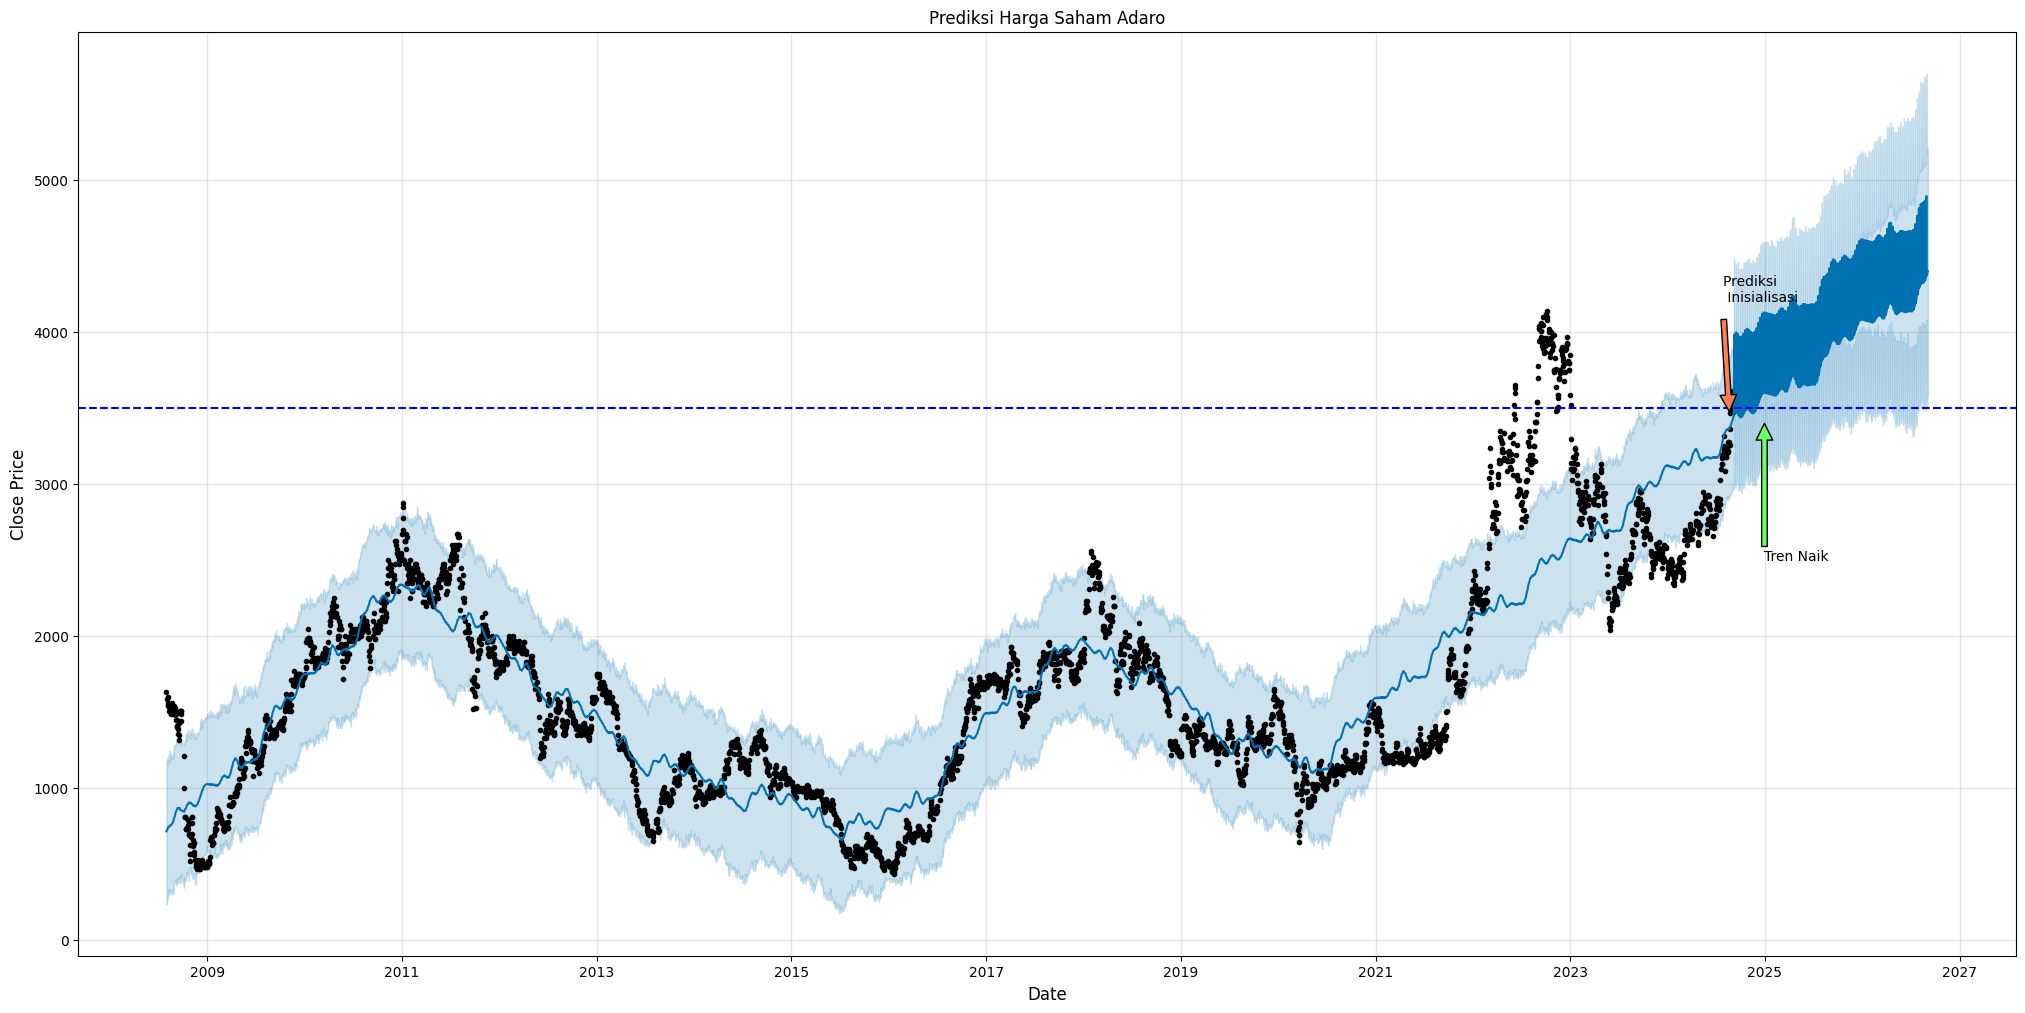

In [11]:
# Dates
start_date = dt.datetime(2024, 7, 27)
start_date1 = mdates.date2num(start_date)

trend_date = dt.datetime(2024, 12, 30)
trend_date1 = mdates.date2num(trend_date)

point_arrow = dt.datetime(2024, 8, 23)
point_arrow1 = mdates.date2num(point_arrow)

# plot
fig, ax1 = plt.subplots(figsize=(25, 12))
model.plot(predict, ax=ax1)
ax1.set_title('Prediksi Harga Saham Adaro')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Close Price', fontsize=12)

# anotasi
ax1.annotate('Prediksi \n Inisialisasi', xy=(point_arrow1, 3400), xytext=(start_date1, 4200), 
             arrowprops=dict(facecolor='#ff7f50', shrink=0.1),
             )
ax1.annotate('Tren Naik', xy=(trend_date1, 3400), xytext=(trend_date1, 2500), 
             arrowprops=dict(facecolor='#6cff6c', shrink=0.0),
             )

ax1.axhline(y=3500, color='b', linestyle='--')
plt.show()

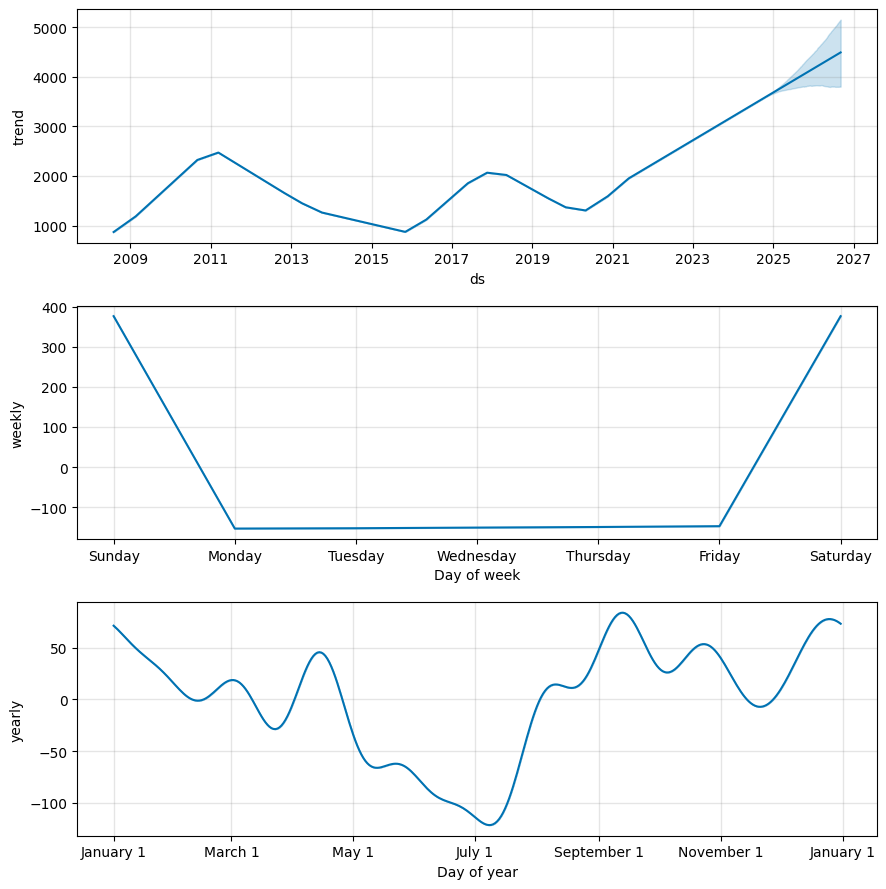

In [13]:
fig2 = model.plot_components(predict)
plt.show()

00:46:25 - cmdstanpy - INFO - Chain [1] start processing
00:46:29 - cmdstanpy - INFO - Chain [1] done processing


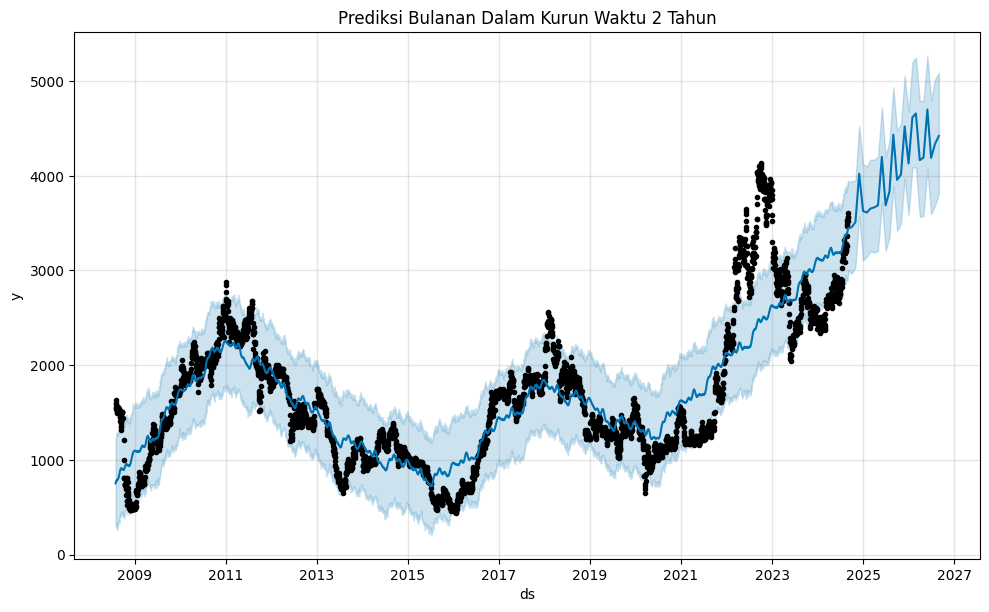

In [14]:
# Prediksi Data Bulanan
model_adro = Prophet(changepoint_prior_scale=0.02).fit(model_df)
future = model_adro.make_future_dataframe(periods=24, freq='M')
forecast = model_adro.predict(future)
fig = model_adro.plot(forecast)
plt.title('Prediksi Bulanan Dalam Kurun Waktu 2 Tahun')

# menampilkan plot
plt.show()

#### 2. Forecasting Saham BUMI

#### 3. Forecasting Saham BYAN

#### 4. Forecasting Saham GEMS

#### 5. Forecasting Saham INDY

#### 6. Forecasting Saham ITMG

#### 7. Forecasting Saham PTBA